In [1]:
import numpy as np         
from numpy.linalg import inv, multi_dot
import pandas as pd                                      
import matplotlib.pyplot as plt    

from scipy import signal
from scipy.optimize import minimize, root

pd.core.common.is_list_like = pd.api.types.is_list_like  
from pandas_datareader.data import DataReader      

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data

In [2]:
fred_gdp = DataReader("GNPC96", "fred", "1900-01-01", '1987Q3').rename(columns = {"GNPC96":"Y"})
fred_u = DataReader("UNRATE", "fred", "1900-01-01", '1987Q3').rename(columns = {"UNRATE":"U"})
data = pd.concat([fred_gdp, fred_u], axis=1, join_axes=[fred_gdp.index]).dropna()
data.index.name = "Date"; data.index = pd.date_range("1948Q1",'1987Q4',freq="Q")
data["ΔY"] = np.log(data.Y).diff()*400; data = data.dropna()
data.loc[:"1973Q2","ΔY_detrended"] = signal.detrend(data.loc[:"1973Q2","ΔY"], type="constant")
data.loc["1973Q3":,"ΔY_detrended"] = signal.detrend(data.loc["1973Q3":,"ΔY"], type="constant")
data["U_detrended"] = signal.detrend(data["U"])
X = data.loc[:,["ΔY_detrended","U_detrended"]].rename(columns={"ΔY_detrended":"ΔY", "U_detrended":"U"})

In [3]:
X.head()

,ΔY,U
1948-06-30,2.641564,0.094435
1948-09-30,-1.709047,-0.229488
1948-12-31,-3.551231,-0.153411
1949-03-31,-9.619173,0.422665
1949-06-30,-5.421834,1.398742


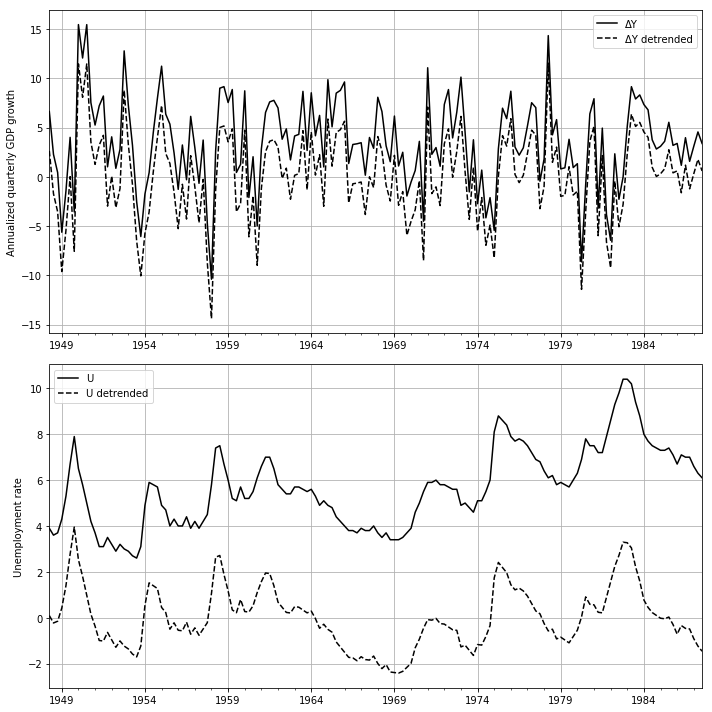

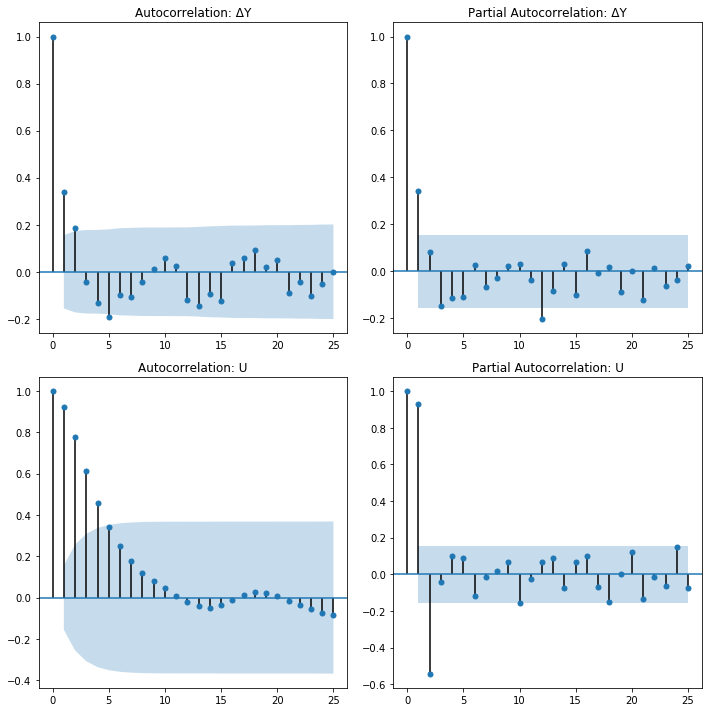

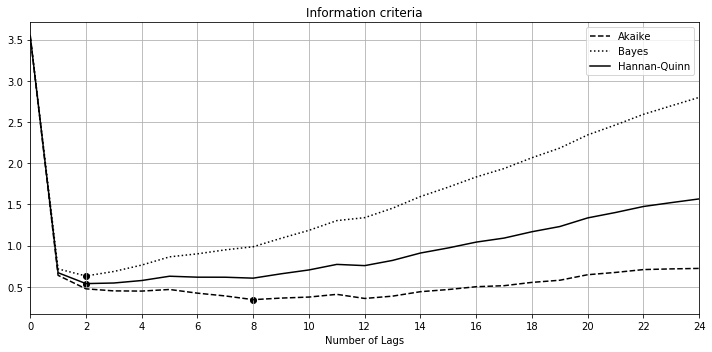

In [10]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10)); axes = axes.flatten()
for i, x in enumerate(["ΔY", "U"]):
    data[x].plot(ax=axes[i], color="k")
    data[x+"_detrended"].plot(ax=axes[i], linestyle="--", color="k")
    axes[i].legend([x, x+" detrended"])
    axes[i].set_ylabel(["Annualized quarterly GDP growth", 'Unemployment rate'][i])
    axes[i].grid()
plt.tight_layout() 

f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10)); axes = axes.flatten()
for i, x in enumerate(["ΔY", "U"]):
    plot_acf(X[x], lags=25, ax=axes[i*2], title="Autocorrelation: "+x)
    plot_pacf(X[x], lags=25, ax=axes[i*2+1], title="Partial Autocorrelation: "+x)
plt.tight_layout()

IC = np.zeros((25,3))
for r in range(IC.shape[0]):
    mod = VAR(X).fit(r, trend='nc', )
    IC[r,:] = [mod.aic, mod.bic, mod.hqic]
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
for c in range(IC.shape[1]):
    xval, yval = np.where(IC[:,c]==np.amin(IC[:,c]))[0][0], np.amin(IC[:,c])
    ax.scatter(x=xval,y=yval, color="k")
IC = pd.DataFrame(IC, index=range(IC.shape[0]), columns=["Akaike", "Bayes", "Hannan-Quinn"])
IC.plot(style=['k--','k:','k-'], ax=ax)
ax.set_title("Information criteria")
ax.set_xlabel("Number of Lags")
ax.grid()
ax.xaxis.set_ticks(np.arange(0, 25, 2))
plt.tight_layout()

# Preproc

In [11]:
def preproc(X, num_lags):
    XLAG = pd.DataFrame()
    for i in range(1,num_lags+1):
        XLAG = pd.concat([XLAG,X.shift(i).add_suffix("-"+str(i))],axis=1)
    return np.array(X.iloc[num_lags:,:]), np.array(XLAG.iloc[num_lags:,:])

In [12]:
num_lags = 8
X_, X_lag = preproc(X, num_lags)
num_obs, num_vars = X_.shape
A_hat = multi_dot([inv(np.dot(X_lag.T,X_lag)),X_lag.T,X_])

ε = X_ - np.dot(X_lag,A_hat)
V_hat = np.dot(ε.T, ε)/(num_obs - num_lags*num_vars)
c_A_hat = np.vstack((A_hat.T,np.hstack((np.identity((num_lags-1)*num_vars),np.zeros([(num_lags-1)*num_vars,num_vars]))))) 

#Setting up for LR restriction
c_M_hat = inv(np.identity(c_A_hat.shape[0])-c_A_hat)
M_hat = c_M_hat[:2,:2]

In [13]:
def objective(x0, Mhat, Vhat, num_vars):        #objective function, starts with x0, outputs H, which it uses again as x0 until convergence
        G = np.reshape(x0,[num_vars,num_vars])  #grab starting values, and create a possible matrix G, or A(0)
        LR = np.dot(Mhat,G)                     #LR effect given by multiplication of Mhat and G
        H = np.dot(G,G.T) - Vhat                #G is supposed to be A(0), hence A(0)*A(0).T should be equal to Vhat, as variance of shocks is identity
        H[0,1] = LR[0,1]                        #However, we add LR restriction
        H = H.flatten()
        return H                                #each parameter in H must be equal to 0, including LR restriction

In [14]:
x0 = ((V_hat**2)**.25).flatten() #Starting values, flatten is needed for root function below
#returns the values of G, A(0), which guarantee LR restriction = 0, as well as the information from variance-covariance matrix
sol = root(objective, x0, args=(M_hat,V_hat,num_vars)) # Solves F(X) = 0, where both X and 0 can be vectors
G = sol.x.reshape([num_vars,num_vars]) 
A0 = G
#the first shock (supply) should have a positive impact on output (only redefines direction, and changes nothing)
if G[0,0] < 0: G[:,0] = -G[:,0]

#the second shock (demand) should have a positive impact on output (only redefines direction, and changes nothing)
if G[0,1] < 0: G[:,1] = -G[:,1]

#Estimating structural shocks, ETA, as per 6/13, Class4
F = inv(G)
ETA = np.dot(ε,F.T)

In [15]:
#IRFs
'''IRFs are stored in a 3-dimensional array. Dimension 1 is time. Dimension
    2 is variable, and 3 is shock. So IRF(:,2,1) gives the impulse response
    of the second variable to the first shock. IRF_sum gives the integrated
    responses (i.e, in levels). IRF_sum(:,1,1) gives the cumulative impulse
    response of variable 1 to shock 1.'''
    
num_impulses = 40
IRF = np.zeros([num_impulses,num_vars,num_vars])
Temp = np.identity(c_A_hat.shape[0])

psi = []
for t in range(num_impulses):
    psi_t = Temp[:num_vars,:num_vars] 
    IRF[t,:,:] = np.dot(psi_t,G) # store the IRF
    Temp = np.dot(c_A_hat,Temp)   # computes the exponent of the matrix
    #psi.append(psi_t)            # stores the matrices Psi (notations as in Hamilton)

irf = pd.DataFrame({i:IRF[i].flatten() for i in range(num_impulses)}).T #save IRFs into dataframe
irf.columns = ["s_y","d_y","s_u","d_u"]
irf_cum = irf.cumsum() #output is expressed cumulatively

irf_final = pd.concat([irf_cum["s_y"], #supply shock on output
                        irf_cum["d_y"], #demand shock on output
                        irf["s_u"], #supply shock on unemployment
                        irf["d_u"]],axis=1) #demand shock on unemployment

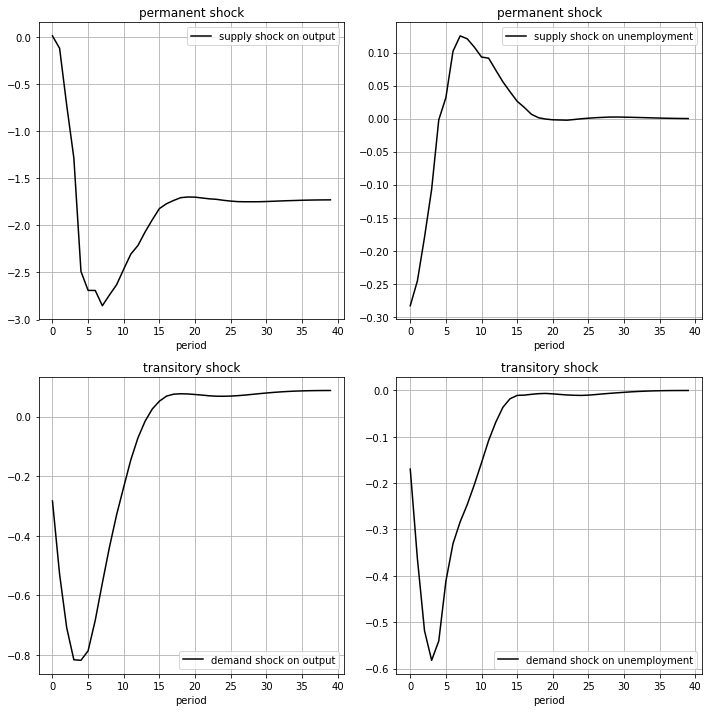

In [16]:
labels = ['supply shock on output', 'supply shock on unemployment', 'demand shock on output', 'demand shock on unemployment']
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10)); axes = axes.flatten()
for i, x in enumerate([irf_cum["s_y"], irf["s_u"], irf_cum["s_u"], irf["d_u"]]):
    axes[i].plot(x, label=labels[i], color="k")
    axes[i].legend()
    axes[i].set_xlabel('period')
    axes[i].set_title(['transitory','permanent'][i<2]+' shock')
    axes[i].grid()
plt.tight_layout()